### Import

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, shape
import seaborn as sns
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import datetime

sys.path.insert(0, '../..')

print("Start: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

from network_v12_13_max import *
from helper_v12_13_max import *

Start: 2025-07-13 00:29:40


### Initialization

#### define agent and gnv boundary

In [2]:
fl_city_boundary = gpd.read_file('Map/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE'].reset_index(drop=True)
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'].to_crs('epsg:4326')

grid_centroid_gdf = pd.read_csv('grid_centroid_gdf.csv')
grid_centroid_gdf = grid_centroid_gdf.drop(columns = {'geometry'}, axis = 1)
grid_centroid_gdf['geometry'] = grid_centroid_gdf[['longitude', 'latitude']].values.tolist()
grid_centroid_gdf['geometry'] = grid_centroid_gdf['geometry'].apply(Point)

grid_centroid_gdf = grid_centroid_gdf.loc[grid_centroid_gdf['departure_rate'] > 0].reset_index()

grid_centroid_gdf.head()

,level_0,index,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop,rider_test_list,geometry
0,0,29,29.658570,-82.415016,0.022484,0.038544,0.081538,1.0,0.030854,1.0,0,POINT (-82.41501609853275 29.65857013179353)
1,1,30,29.660371,-82.414990,0.002141,0.005353,1.000000,0.0,1.000000,0.0,0,POINT (-82.4149895039865 29.660371378494247)
2,2,47,29.654944,-82.413000,0.001071,0.002141,1.000000,0.0,1.000000,0.0,0,POINT (-82.41300040184892 29.654944475167262)
3,3,48,29.656746,-82.412974,0.004283,0.008565,1.000000,0.0,1.000000,0.0,0,POINT (-82.41297377438231 29.65674571873145)
4,4,49,29.658547,-82.412947,0.078158,0.100642,1.000000,0.0,1.000000,0.0,1,POINT (-82.41294714602218 29.6585469636598)


#### scooter-sharing system configure

In [3]:
service_areas = [] # replace stations
for i in range (len(grid_centroid_gdf)):
    service_areas.append((i, grid_centroid_gdf.geometry.iloc[i], grid_centroid_gdf.departure_rate.iloc[i], grid_centroid_gdf.arrival_rate.iloc[i], grid_centroid_gdf.dist_transPOI.iloc[i], grid_centroid_gdf.num_transPOI.iloc[i]))

# Parameter setups for the reward system and elements of the environment.
docked_cost_per_deploy = 50/365 # each dock cost 500
scooter_cost_per_deploy = 25/365 # each scooter 250
no_scooter_penalty = 0.5 # 0.5
reward_per_rider = 0.2 # 0.2
max_scooter_per_area = 8
nS = len(service_areas)
equity_penalty = 100.0
logistics_car_cost_per_mile = 1.0

reward_num_transPOI = 0.01
# penalty_dist_transPOI = 0.1

# dist_transPOI_penalty = 0.5
# low_usage_penalty = 1
# dist_bus_stop_penalty = 0.2
# reward_bus_scooter_coverage = 0.2

#### RL model configure

In [4]:
# Parameter setups for the network and training process.
learning_rate = 0.01
n_iters = 25
n_epochs = 500 # 2000
display_step = 50 # 50
batch_size = 256
gamma = 0.9

# The size of the state vector.
nS = len(service_areas) # the number of service areas

## penalty_dist_transPOI = 0.0

In [5]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.0

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_2, avg_unmet_demand_max_2, avg_met_demand_max_2, avg_scooter_num_max_2, avg_scooter_loc_max_2, avg_wANNR_max_2, avg_moran_max_2, avg_gini_max_2, avg_theil_max_2, avg_EMD_max_2, avg_centroid_max_2, avg_dispersion_max_2, avg_kl_max_2, scooter_list_max_2 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -0.586, 34.200, 156.800, 174.200, 103.800, 0.988, 0.954, 0.472, 0.037, 0.948, 0.210, 1.988, 0.930, -1.722, 0.854
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -11.805, 52.200, 138.800, 168.600, 107.000, 0.981, 0.959, 0.464, 0.038, 0.945, 0.185, 1.935, 0.875, -1.649, 0.901
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = 0.892, 31.000, 160.000, 178.400, 105.200, 0.989, 0.954, 0.477, 0.038, 0.948, 0.212, 1.981, 0.933, -1.707, 0.850
Epoch 200, Average 

## penalty_dist_transPOI = 0.1

In [6]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.1

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_3, avg_unmet_demand_max_3, avg_met_demand_max_3, avg_scooter_num_max_3, avg_scooter_loc_max_3, avg_wANNR_max_3, avg_moran_max_3, avg_gini_max_3, avg_theil_max_3, avg_EMD_max_3, avg_centroid_max_3, avg_dispersion_max_3, avg_kl_max_3, scooter_list_max_3 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -158.786, 98.000, 93.000, 176.000, 112.000, 0.964, 0.974, 0.474, 0.041, 0.943, 0.193, 2.012, 1.070, -1.769, 0.771
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -158.786, 98.000, 93.000, 176.000, 112.000, 0.964, 0.974, 0.474, 0.041, 0.943, 0.193, 2.012, 1.070, -1.769, 0.771
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -158.786, 98.000, 93.000, 176.000, 112.000, 0.964, 0.974, 0.474, 0.041, 0.943, 0.193, 2.012, 1.070, -1.769, 0.771
Epoch 200, Avera

## penalty_dist_transPOI = 0.2

In [7]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.2

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_4, avg_unmet_demand_max_4, avg_met_demand_max_4, avg_scooter_num_max_4, avg_scooter_loc_max_4, avg_wANNR_max_4, avg_moran_max_4, avg_gini_max_4, avg_theil_max_4, avg_EMD_max_4, avg_centroid_max_4, avg_dispersion_max_4, avg_kl_max_4, scooter_list_max_4 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -225.654, 28.600, 162.400, 182.600, 107.400, 0.989, 0.955, 0.484, 0.036, 0.947, 0.224, 1.954, 0.942, -1.664, 0.843
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -224.004, 25.600, 165.400, 185.000, 108.000, 0.989, 0.955, 0.487, 0.038, 0.947, 0.227, 2.004, 0.927, -1.724, 0.848
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -225.822, 29.600, 161.400, 179.800, 106.800, 0.989, 0.954, 0.480, 0.042, 0.947, 0.204, 2.029, 0.924, -1.765, 0.823
Epoch 200, Av

## penalty_dist_transPOI = 0.3

In [8]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.3

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_5, avg_unmet_demand_max_5, avg_met_demand_max_5, avg_scooter_num_max_5, avg_scooter_loc_max_5, avg_wANNR_max_5, avg_moran_max_5, avg_gini_max_5, avg_theil_max_5, avg_EMD_max_5, avg_centroid_max_5, avg_dispersion_max_5, avg_kl_max_5, scooter_list_max_5 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -337.836, 26.000, 165.000, 183.000, 105.200, 0.989, 0.955, 0.484, 0.040, 0.949, 0.226, 2.007, 0.910, -1.712, 0.824
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -341.693, 32.800, 158.200, 179.800, 108.600, 0.987, 0.955, 0.479, 0.040, 0.946, 0.211, 2.017, 0.964, -1.759, 0.808
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -338.237, 26.800, 164.200, 183.000, 107.400, 0.990, 0.955, 0.484, 0.041, 0.947, 0.210, 2.021, 0.930, -1.755, 0.820
Epoch 200, Av

## penalty_dist_transPOI = 0.4

In [9]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.4

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_6, avg_unmet_demand_max_6, avg_met_demand_max_6, avg_scooter_num_max_6, avg_scooter_loc_max_6, avg_wANNR_max_6, avg_moran_max_6, avg_gini_max_6, avg_theil_max_6, avg_EMD_max_6, avg_centroid_max_6, avg_dispersion_max_6, avg_kl_max_6, scooter_list_max_6 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -457.507, 36.400, 154.600, 177.600, 108.800, 0.987, 0.953, 0.476, 0.039, 0.945, 0.189, 1.972, 0.971, -1.705, 0.828
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -496.796, 94.000, 97.000, 173.000, 110.000, 0.966, 0.973, 0.470, 0.041, 0.944, 0.191, 1.953, 1.005, -1.676, 0.866
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -496.796, 94.000, 97.000, 173.000, 110.000, 0.966, 0.973, 0.470, 0.041, 0.944, 0.191, 1.953, 1.005, -1.676, 0.866
Epoch 200, Aver

## penalty_dist_transPOI = 0.5

In [10]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.5

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_7, avg_unmet_demand_max_7, avg_met_demand_max_7, avg_scooter_num_max_7, avg_scooter_loc_max_7, avg_wANNR_max_7, avg_moran_max_7, avg_gini_max_7, avg_theil_max_7, avg_EMD_max_7, avg_centroid_max_7, avg_dispersion_max_7, avg_kl_max_7, scooter_list_max_7 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -568.553, 32.800, 158.200, 175.600, 105.800, 0.989, 0.954, 0.474, 0.039, 0.947, 0.188, 1.973, 0.973, -1.679, 0.871
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -616.561, 104.000, 87.000, 165.000, 101.000, 0.961, 0.974, 0.459, 0.042, 0.950, 0.203, 2.104, 0.952, -1.926, 0.709
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -607.479, 92.000, 99.000, 165.400, 111.600, 0.968, 0.969, 0.460, 0.037, 0.942, 0.191, 1.904, 0.870, -1.668, 0.841
Epoch 200, Ave

## penalty_dist_transPOI = 0.6

In [11]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.6

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_8, avg_unmet_demand_max_8, avg_met_demand_max_8, avg_scooter_num_max_8, avg_scooter_loc_max_8, avg_wANNR_max_8, avg_moran_max_8, avg_gini_max_8, avg_theil_max_8, avg_EMD_max_8, avg_centroid_max_8, avg_dispersion_max_8, avg_kl_max_8, scooter_list_max_8 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -681.203, 30.200, 160.800, 179.400, 106.800, 0.988, 0.955, 0.479, 0.037, 0.947, 0.212, 1.972, 0.958, -1.694, 0.850
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -688.072, 40.000, 151.000, 181.200, 111.800, 0.982, 0.959, 0.481, 0.038, 0.944, 0.210, 1.972, 0.949, -1.682, 0.856
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -679.440, 27.400, 163.600, 179.800, 105.200, 0.989, 0.955, 0.479, 0.037, 0.948, 0.224, 2.022, 0.937, -1.767, 0.834
Epoch 200, Av

## penalty_dist_transPOI = 0.7

In [12]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.7

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_9, avg_unmet_demand_max_9, avg_met_demand_max_9, avg_scooter_num_max_9, avg_scooter_loc_max_9, avg_wANNR_max_9, avg_moran_max_9, avg_gini_max_9, avg_theil_max_9, avg_EMD_max_9, avg_centroid_max_9, avg_dispersion_max_9, avg_kl_max_9, scooter_list_max_9 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -801.552, 42.800, 148.200, 168.400, 106.400, 0.987, 0.953, 0.464, 0.040, 0.945, 0.174, 1.953, 0.959, -1.667, 0.858
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -817.535, 66.600, 124.400, 163.000, 100.400, 0.971, 0.964, 0.456, 0.043, 0.949, 0.192, 2.072, 0.954, -1.801, 0.781
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -839.421, 99.000, 92.000, 159.000, 100.000, 0.960, 0.974, 0.451, 0.039, 0.949, 0.174, 1.941, 0.860, -1.630, 0.806
Epoch 200, Ave

## penalty_dist_transPOI = 0.8

In [13]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.8

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_10, avg_unmet_demand_max_10, avg_met_demand_max_10, avg_scooter_num_max_10, avg_scooter_loc_max_10, avg_wANNR_max_10, avg_moran_max_10, avg_gini_max_10, avg_theil_max_10, avg_EMD_max_10, avg_centroid_max_10, avg_dispersion_max_10, avg_kl_max_10, scooter_list_max_10 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -955.860, 104.000, 87.000, 155.000, 100.000, 0.961, 0.973, 0.445, 0.036, 0.948, 0.173, 1.894, 0.903, -1.646, 0.854
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -955.860, 104.000, 87.000, 155.000, 100.000, 0.961, 0.973, 0.445, 0.036, 0.948, 0.173, 1.894, 0.903, -1.646, 0.854
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -953.993, 99.000, 92.000, 164.000, 103.000, 0.960, 0.975, 0.458, 0.045, 0.948, 0.199, 2.066, 0.842, -1.847, 0.882
Epoch 200, Ave

## penalty_dist_transPOI = 0.9

In [14]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 0.9

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_11, avg_unmet_demand_max_11, avg_met_demand_max_11, avg_scooter_num_max_11, avg_scooter_loc_max_11, avg_wANNR_max_11, avg_moran_max_11, avg_gini_max_11, avg_theil_max_11, avg_EMD_max_11, avg_centroid_max_11, avg_dispersion_max_11, avg_kl_max_11, scooter_list_max_11 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1022.047, 28.400, 162.600, 183.400, 106.800, 0.988, 0.955, 0.484, 0.038, 0.948, 0.222, 1.975, 0.932, -1.683, 0.842
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1021.716, 28.400, 162.600, 180.600, 103.400, 0.989, 0.955, 0.480, 0.041, 0.950, 0.214, 2.049, 0.910, -1.780, 0.813
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1022.274, 29.200, 161.800, 180.800, 104.000, 0.988, 0.955, 0.481, 0.041, 0.949, 0.216, 2.035, 0.907, -1.762, 0.836
Epoch 200,

## penalty_dist_transPOI = 1.0

In [15]:
## tf.reset_default_graph() only works under tf 1.0
penalty_dist_transPOI = 1.0

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, \
                              penalty_dist_transPOI, reward_num_transPOI)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_12, avg_unmet_demand_max_12, avg_met_demand_max_12, avg_scooter_num_max_12, avg_scooter_loc_max_12, avg_wANNR_max_12, avg_moran_max_12, avg_gini_max_12, avg_theil_max_12, avg_EMD_max_12, avg_centroid_max_12, avg_dispersion_max_12, avg_kl_max_12, scooter_list_max_12 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1138.108, 32.200, 158.800, 182.000, 107.800, 0.987, 0.954, 0.482, 0.039, 0.947, 0.217, 2.006, 0.939, -1.737, 0.781
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1146.907, 47.400, 143.600, 170.800, 101.400, 0.981, 0.960, 0.467, 0.039, 0.950, 0.219, 2.059, 0.922, -1.786, 0.808
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, gini index unmet, gini index met, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -1160.511, 63.600, 127.400, 184.200, 108.200, 0.972, 0.965, 0.485, 0.038, 0.947, 0.202, 2.023, 0.970, -1.825, 0.786
Epoch 200,

# Illustration

In [16]:
def modified_z_score(arr):

    median = np.median(arr)
    mad = np.median(np.abs(arr - median))  # Median Absolute Deviation

    # Modified Z-score
    modified_z_scores = 0.6745 * (arr - median) / mad
    threshold = 3
    # filtered_arr = arr[np.abs(modified_z_scores) < threshold]
    sel_index = np.abs(modified_z_scores) < threshold
    
    return sel_index # filtered_arr

sel_index_2 = modified_z_score(avg_reward_max_2)
sel_index_3 = modified_z_score(avg_reward_max_3)
sel_index_4 = modified_z_score(avg_reward_max_4)
sel_index_5 = modified_z_score(avg_reward_max_5)
sel_index_6 = modified_z_score(avg_reward_max_6)
sel_index_7 = modified_z_score(avg_reward_max_7)
sel_index_8 = modified_z_score(avg_reward_max_8)
sel_index_9 = modified_z_score(avg_reward_max_9)
sel_index_10 = modified_z_score(avg_reward_max_10)
sel_index_11 = modified_z_score(avg_reward_max_11)
sel_index_12 = modified_z_score(avg_reward_max_12)
print([sel_index_2, sel_index_3, sel_index_4, sel_index_5, sel_index_6, sel_index_7, sel_index_8, sel_index_9, 
      sel_index_10, sel_index_11, sel_index_12])

[array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False]), array([False, False, False, False, False, False, False, False, False,
       False]), array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True]), array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True]), array([False, False, False, False, False, False, False, False, False,
       False]), array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([False, False, False, False, False, False, False, False, False,
       False]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True])]


C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17436\3902648579.py:7: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = 0.6745 * (arr - median) / mad
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17436\3902648579.py:7: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = 0.6745 * (arr - median) / mad


End: 2025-07-13 03:42:45
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


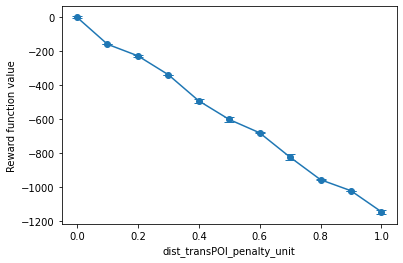

In [17]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

dist_transPOI_penalty_unit_list = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
max_reward_list_grid = np.array([avg_reward_max_2,
                                avg_reward_max_3,
                                avg_reward_max_4,
                                avg_reward_max_5,
                                avg_reward_max_6,
                                avg_reward_max_7,
                                avg_reward_max_8,
                                avg_reward_max_9,
                                avg_reward_max_10,
                                avg_reward_max_11,
                                avg_reward_max_12])
max_reward_mean_grid = np.mean(max_reward_list_grid, axis=1)
max_reward_std_grid = np.std(max_reward_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_reward_mean_grid, yerr=max_reward_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Reward function value")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [18]:
max_reward_list_grid

array([[-5.86134381e-01, -1.18049019e+01,  8.91716474e-01,
         1.90308673e+00,  3.32851407e+00,  2.08751293e+00,
         2.12750424e+00,  2.03541550e+00,  3.92414788e+00,
        -1.25632067e+01],
       [-1.58785914e+02, -1.58785914e+02, -1.58785914e+02,
        -1.58785914e+02, -1.58785914e+02, -1.58785914e+02,
        -1.58785914e+02, -1.61053037e+02, -1.61053037e+02,
        -1.61053037e+02],
       [-2.25654186e+02, -2.24004109e+02, -2.25822071e+02,
        -2.25978612e+02, -2.36958894e+02, -2.24994177e+02,
        -2.38402979e+02, -2.25838175e+02, -2.24706163e+02,
        -2.25963098e+02],
       [-3.37835574e+02, -3.41693083e+02, -3.38237072e+02,
        -3.37447971e+02, -3.39039135e+02, -3.38230334e+02,
        -3.39663339e+02, -3.39289974e+02, -3.38564657e+02,
        -3.38673613e+02],
       [-4.57507313e+02, -4.96795653e+02, -4.96795653e+02,
        -4.96767099e+02, -4.96767099e+02, -4.96767099e+02,
        -4.96767099e+02, -4.96767099e+02, -4.96767099e+02,
        -4.

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


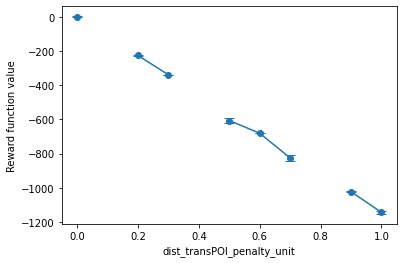

In [19]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_reward_list_grid = [np.array(avg_reward_max_2)[sel_index_2],
                        np.array(avg_reward_max_3)[sel_index_3],
                        np.array(avg_reward_max_4)[sel_index_4],
                        np.array(avg_reward_max_5)[sel_index_5],
                        np.array(avg_reward_max_6)[sel_index_6],
                        np.array(avg_reward_max_7)[sel_index_7],
                        np.array(avg_reward_max_8)[sel_index_8],
                        np.array(avg_reward_max_9)[sel_index_9],
                        np.array(avg_reward_max_10)[sel_index_10],
                        np.array(avg_reward_max_11)[sel_index_11],
                        np.array(avg_reward_max_12)[sel_index_12]]
max_reward_mean_grid = []
max_reward_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_reward_mean_grid.append(np.mean(max_reward_list_grid[ii]))
    max_reward_std_grid.append(np.std(max_reward_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_reward_mean_grid, yerr=max_reward_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Reward function value")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


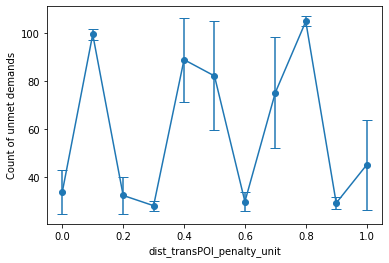

In [20]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_unmet_demand_list_grid = np.array([avg_unmet_demand_max_2,
                                avg_unmet_demand_max_3,
                                avg_unmet_demand_max_4,
                                avg_unmet_demand_max_5,
                                avg_unmet_demand_max_6,
                                avg_unmet_demand_max_7,
                                avg_unmet_demand_max_8,
                                avg_unmet_demand_max_9,
                                avg_unmet_demand_max_10,
                                avg_unmet_demand_max_11,
                                avg_unmet_demand_max_12])
max_unmet_demand_mean_grid = np.mean(max_unmet_demand_list_grid, axis=1)
max_unmet_demand_std_grid = np.std(max_unmet_demand_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_unmet_demand_mean_grid, yerr=max_unmet_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of unmet demands")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [21]:
max_unmet_demand_list_grid

array([[ 34.2,  52.2,  31. ,  30.4,  25.4,  29.4,  28.8,  29.8,  25.4,
         50.8],
       [ 98. ,  98. ,  98. ,  98. ,  98. ,  98. ,  98. , 103. , 103. ,
        103. ],
       [ 28.6,  25.6,  29.6,  29.8,  46. ,  28.2,  49. ,  27.8,  27.8,
         30.4],
       [ 26. ,  32.8,  26.8,  25.2,  28.6,  26.4,  29.6,  28.6,  28.6,
         27.4],
       [ 36.4,  94. ,  94. ,  95. ,  95. ,  95. ,  95. ,  95. ,  95. ,
         95. ],
       [ 32.8, 104. ,  92. ,  98. ,  99. ,  43.8,  91. ,  84.2,  89.2,
         87.4],
       [ 30.2,  40. ,  27.4,  29.6,  32. ,  29.2,  28.4,  25. ,  29.8,
         25.4],
       [ 42.8,  66.6,  99. ,  58.6,  32. ,  97. , 101. ,  95. ,  77. ,
         83.2],
       [104. , 104. ,  99. , 106. , 106. , 106. , 106. , 106. , 106. ,
        106. ],
       [ 28.4,  28.4,  29.2,  30.6,  26. ,  29. ,  28. ,  26. ,  31. ,
         34.4],
       [ 32.2,  47.4,  63.6,  25.6,  44.8,  84.4,  29.8,  28.6,  29.4,
         64.4]])

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


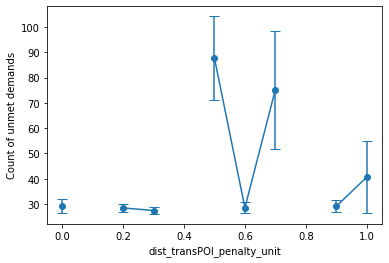

In [22]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_unmet_demand_list_grid = [np.array(avg_unmet_demand_max_2)[sel_index_2],
                        np.array(avg_unmet_demand_max_3)[sel_index_3],
                        np.array(avg_unmet_demand_max_4)[sel_index_4],
                        np.array(avg_unmet_demand_max_5)[sel_index_5],
                        np.array(avg_unmet_demand_max_6)[sel_index_6],
                        np.array(avg_unmet_demand_max_7)[sel_index_7],
                        np.array(avg_unmet_demand_max_8)[sel_index_8],
                        np.array(avg_unmet_demand_max_9)[sel_index_9],
                        np.array(avg_unmet_demand_max_10)[sel_index_10],
                        np.array(avg_unmet_demand_max_11)[sel_index_11],
                        np.array(avg_unmet_demand_max_12)[sel_index_12]]
max_unmet_demand_mean_grid = []
max_unmet_demand_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_unmet_demand_mean_grid.append(np.mean(max_unmet_demand_list_grid[ii]))
    max_unmet_demand_std_grid.append(np.std(max_unmet_demand_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_unmet_demand_mean_grid, yerr=max_unmet_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of unmet demands")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


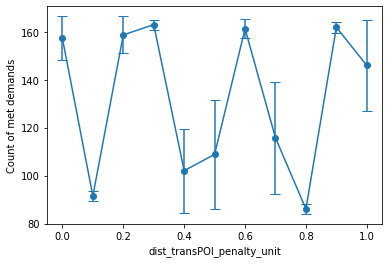

In [23]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_met_demand_list_grid = np.array([avg_met_demand_max_2,
                                avg_met_demand_max_3,
                                avg_met_demand_max_4,
                                avg_met_demand_max_5,
                                avg_met_demand_max_6,
                                avg_met_demand_max_7,
                                avg_met_demand_max_8,
                                avg_met_demand_max_9,
                                avg_met_demand_max_10,
                                avg_met_demand_max_11,
                                avg_met_demand_max_12])
max_met_demand_mean_grid = np.mean(max_met_demand_list_grid, axis=1)
max_met_demand_std_grid = np.std(max_met_demand_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_met_demand_mean_grid, yerr=max_met_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of met demands")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [24]:
max_met_demand_list_grid

array([[156.8, 138.8, 160. , 160.6, 165.6, 161.6, 162.2, 161.2, 165.6,
        140.2],
       [ 93. ,  93. ,  93. ,  93. ,  93. ,  93. ,  93. ,  88. ,  88. ,
         88. ],
       [162.4, 165.4, 161.4, 161.2, 145. , 162.8, 142. , 163.2, 163.2,
        160.6],
       [165. , 158.2, 164.2, 165.8, 162.4, 164.6, 161.4, 162.4, 162.4,
        163.6],
       [154.6,  97. ,  97. ,  96. ,  96. ,  96. ,  96. ,  96. ,  96. ,
         96. ],
       [158.2,  87. ,  99. ,  93. ,  92. , 147.2, 100. , 106.8, 101.8,
        103.6],
       [160.8, 151. , 163.6, 161.4, 159. , 161.8, 162.6, 166. , 161.2,
        165.6],
       [148.2, 124.4,  92. , 132.4, 159. ,  94. ,  90. ,  96. , 114. ,
        107.8],
       [ 87. ,  87. ,  92. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ],
       [162.6, 162.6, 161.8, 160.4, 165. , 162. , 163. , 165. , 160. ,
        156.6],
       [158.8, 143.6, 127.4, 165.4, 146.2, 106.6, 161.2, 162.4, 161.6,
        126.6]])

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


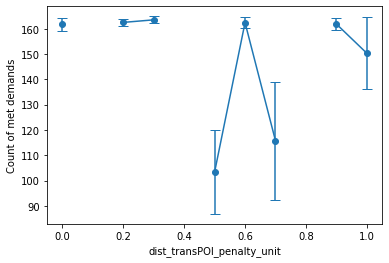

In [25]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_met_demand_list_grid = [np.array(avg_met_demand_max_2)[sel_index_2],
                        np.array(avg_met_demand_max_3)[sel_index_3],
                        np.array(avg_met_demand_max_4)[sel_index_4],
                        np.array(avg_met_demand_max_5)[sel_index_5],
                        np.array(avg_met_demand_max_6)[sel_index_6],
                        np.array(avg_met_demand_max_7)[sel_index_7],
                        np.array(avg_met_demand_max_8)[sel_index_8],
                        np.array(avg_met_demand_max_9)[sel_index_9],
                        np.array(avg_met_demand_max_10)[sel_index_10],
                        np.array(avg_met_demand_max_11)[sel_index_11],
                        np.array(avg_met_demand_max_12)[sel_index_12]]
max_met_demand_mean_grid = []
max_met_demand_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_met_demand_mean_grid.append(np.mean(max_met_demand_list_grid[ii]))
    max_met_demand_std_grid.append(np.std(max_met_demand_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_met_demand_mean_grid, yerr=max_met_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of met demands")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


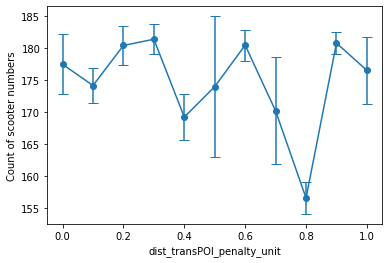

In [26]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_num_list_grid = np.array([avg_scooter_num_max_2,
                                avg_scooter_num_max_3,
                                avg_scooter_num_max_4,
                                avg_scooter_num_max_5,
                                avg_scooter_num_max_6,
                                avg_scooter_num_max_7,
                                avg_scooter_num_max_8,
                                avg_scooter_num_max_9,
                                avg_scooter_num_max_10,
                                avg_scooter_num_max_11,
                                avg_scooter_num_max_12])
max_scooter_num_mean_grid = np.mean(max_scooter_num_list_grid, axis=1)
max_scooter_num_std_grid = np.std(max_scooter_num_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_scooter_num_mean_grid, yerr=max_scooter_num_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter numbers")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [27]:
max_scooter_num_list_grid

array([[174.2, 168.6, 178.4, 174.4, 186.6, 177.4, 179.6, 175.8, 183. ,
        177.2],
       [176. , 176. , 176. , 176. , 176. , 176. , 176. , 170. , 170. ,
        170. ],
       [182.6, 185. , 179.8, 179.6, 178.2, 180.4, 176.2, 185.8, 179.8,
        177.2],
       [183. , 179.8, 183. , 184.4, 180. , 184.4, 179. , 180.8, 177.2,
        182.8],
       [177.6, 173. , 173. , 167. , 167. , 167. , 167. , 167. , 167. ,
        167. ],
       [175.6, 165. , 165.4, 180. , 181. , 167.4, 198. , 182.8, 160.8,
        164.2],
       [179.4, 181.2, 179.8, 181.4, 179. , 178.2, 178.8, 184.4, 177.8,
        185.2],
       [168.4, 163. , 159. , 178.8, 173.4, 164. , 166. , 187. , 178.2,
        164.4],
       [155. , 155. , 164. , 156. , 156. , 156. , 156. , 156. , 156. ,
        156. ],
       [183.4, 180.6, 180.8, 180.6, 184.4, 179.2, 180.6, 181. , 179. ,
        178.8],
       [182. , 170.8, 184.2, 180.4, 165.8, 177.4, 176.8, 177. , 178.4,
        172.8]])

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


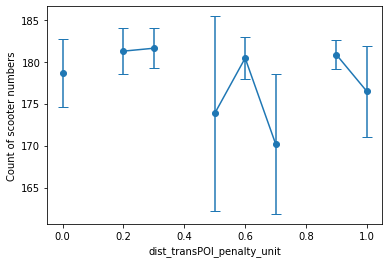

In [28]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_num_list_grid = [np.array(avg_scooter_num_max_2)[sel_index_2],
                        np.array(avg_scooter_num_max_3)[sel_index_3],
                        np.array(avg_scooter_num_max_4)[sel_index_4],
                        np.array(avg_scooter_num_max_5)[sel_index_5],
                        np.array(avg_scooter_num_max_6)[sel_index_6],
                        np.array(avg_scooter_num_max_7)[sel_index_7],
                        np.array(avg_scooter_num_max_8)[sel_index_8],
                        np.array(avg_scooter_num_max_9)[sel_index_9],
                        np.array(avg_scooter_num_max_10)[sel_index_10],
                        np.array(avg_scooter_num_max_11)[sel_index_11],
                        np.array(avg_scooter_num_max_12)[sel_index_12]]
max_scooter_num_mean_grid = []
max_scooter_num_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_scooter_num_mean_grid.append(np.mean(max_scooter_num_list_grid[ii]))
    max_scooter_num_std_grid.append(np.std(max_scooter_num_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_scooter_num_mean_grid, yerr=max_scooter_num_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter numbers")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:46
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:46


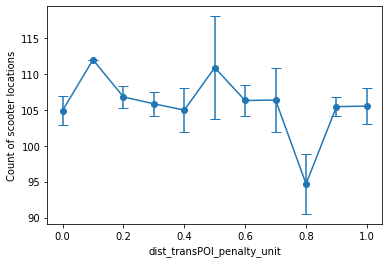

In [29]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_loc_list_grid = np.array([avg_scooter_loc_max_2,
                                avg_scooter_loc_max_3,
                                avg_scooter_loc_max_4,
                                avg_scooter_loc_max_5,
                                avg_scooter_loc_max_6,
                                avg_scooter_loc_max_7,
                                avg_scooter_loc_max_8,
                                avg_scooter_loc_max_9,
                                avg_scooter_loc_max_10,
                                avg_scooter_loc_max_11,
                                avg_scooter_loc_max_12])
max_scooter_loc_mean_grid = np.mean(max_scooter_loc_list_grid, axis=1)
max_scooter_loc_std_grid = np.std(max_scooter_loc_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_scooter_loc_mean_grid, yerr=max_scooter_loc_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter locations")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [30]:
max_scooter_loc_list_grid

array([[103.8, 107. , 105.2, 102. , 108. , 103.4, 104.4, 102. , 106. ,
        107.4],
       [112. , 112. , 112. , 112. , 112. , 112. , 112. , 112. , 112. ,
        112. ],
       [107.4, 108. , 106.8, 106. , 107. , 106.4, 110.4, 106.2, 104.8,
        105.2],
       [105.2, 108.6, 107.4, 106.8, 105.2, 107.6, 103.4, 104. , 103.8,
        106.6],
       [108.8, 110. , 110. , 103. , 103. , 103. , 103. , 103. , 103. ,
        103. ],
       [105.8, 101. , 111.6, 116. , 117. , 106.2, 123. , 119.4, 104.2,
        104.8],
       [106.8, 111.8, 105.2, 105.2, 105.8, 105. , 103.6, 108. , 105.6,
        106.2],
       [106.4, 100.4, 100. , 113.8, 105.4, 108. , 106. , 114. , 105.4,
        104.4],
       [100. , 100. , 103. ,  92. ,  92. ,  92. ,  92. ,  92. ,  92. ,
         92. ],
       [106.8, 103.4, 104. , 106.4, 106.4, 103.8, 105.6, 104.6, 106.6,
        107. ],
       [107.8, 101.4, 108.2, 103. , 104.2, 110. , 104.6, 103.6, 106. ,
        106.6]])

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


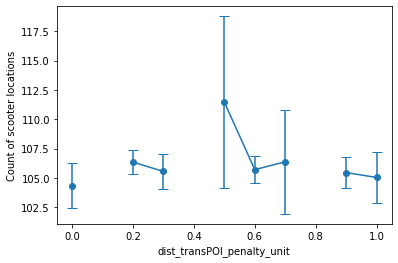

In [31]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_loc_list_grid = [np.array(avg_scooter_loc_max_2)[sel_index_2],
                        np.array(avg_scooter_loc_max_3)[sel_index_3],
                        np.array(avg_scooter_loc_max_4)[sel_index_4],
                        np.array(avg_scooter_loc_max_5)[sel_index_5],
                        np.array(avg_scooter_loc_max_6)[sel_index_6],
                        np.array(avg_scooter_loc_max_7)[sel_index_7],
                        np.array(avg_scooter_loc_max_8)[sel_index_8],
                        np.array(avg_scooter_loc_max_9)[sel_index_9],
                        np.array(avg_scooter_loc_max_10)[sel_index_10],
                        np.array(avg_scooter_loc_max_11)[sel_index_11],
                        np.array(avg_scooter_loc_max_12)[sel_index_12]]
max_scooter_loc_mean_grid = []
max_scooter_loc_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_scooter_loc_mean_grid.append(np.mean(max_scooter_loc_list_grid[ii]))
    max_scooter_loc_std_grid.append(np.std(max_scooter_loc_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_scooter_loc_mean_grid, yerr=max_scooter_loc_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter locations")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


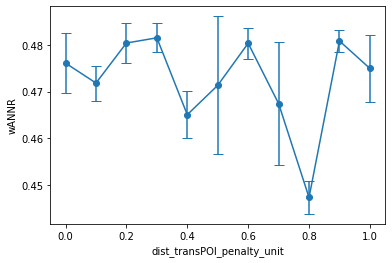

In [32]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_wANNR_list_grid = np.array([avg_wANNR_max_2,
                                avg_wANNR_max_3,
                                avg_wANNR_max_4,
                                avg_wANNR_max_5,
                                avg_wANNR_max_6,
                                avg_wANNR_max_7,
                                avg_wANNR_max_8,
                                avg_wANNR_max_9,
                                avg_wANNR_max_10,
                                avg_wANNR_max_11,
                                avg_wANNR_max_12])
max_wANNR_mean_grid = np.mean(max_wANNR_list_grid, axis=1)
max_wANNR_std_grid = np.std(max_wANNR_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_wANNR_mean_grid, yerr=max_wANNR_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("wANNR")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [33]:
max_wANNR_list_grid

array([[0.47164252, 0.46397663, 0.47737106, 0.47170909, 0.4883503 ,
        0.47596198, 0.47900422, 0.47372565, 0.48358431, 0.47586229],
       [0.47430256, 0.47430256, 0.47430256, 0.47430256, 0.47430256,
        0.47430256, 0.47430256, 0.4661484 , 0.4661484 , 0.4661484 ],
       [0.48433259, 0.48684914, 0.47988165, 0.47906025, 0.47717505,
        0.48006933, 0.47450251, 0.48728306, 0.4792626 , 0.47571852],
       [0.48358438, 0.47934043, 0.48360235, 0.48542714, 0.47952874,
        0.48544389, 0.47872755, 0.48061644, 0.47569672, 0.48331773],
       [0.47642912, 0.47022567, 0.47022567, 0.46199931, 0.46199931,
        0.46199931, 0.46199931, 0.46199931, 0.46199931, 0.46199931],
       [0.47363718, 0.45923345, 0.4597869 , 0.47966165, 0.48098355,
        0.46250233, 0.50307994, 0.48335576, 0.45333103, 0.45807854],
       [0.47873579, 0.4812146 , 0.47924225, 0.4814384 , 0.47819255,
        0.47708184, 0.4784099 , 0.48598261, 0.47683679, 0.48650781],
       [0.46408736, 0.45603546, 0.4508068

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


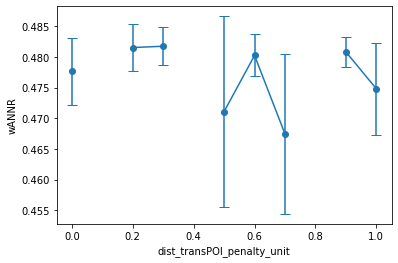

In [34]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_wANNR_list_grid = [np.array(avg_wANNR_max_2)[sel_index_2],
                        np.array(avg_wANNR_max_3)[sel_index_3],
                        np.array(avg_wANNR_max_4)[sel_index_4],
                        np.array(avg_wANNR_max_5)[sel_index_5],
                        np.array(avg_wANNR_max_6)[sel_index_6],
                        np.array(avg_wANNR_max_7)[sel_index_7],
                        np.array(avg_wANNR_max_8)[sel_index_8],
                        np.array(avg_wANNR_max_9)[sel_index_9],
                        np.array(avg_wANNR_max_10)[sel_index_10],
                        np.array(avg_wANNR_max_11)[sel_index_11],
                        np.array(avg_wANNR_max_12)[sel_index_12]]
max_wANNR_mean_grid = []
max_wANNR_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_wANNR_mean_grid.append(np.mean(max_wANNR_list_grid[ii]))
    max_wANNR_std_grid.append(np.std(max_wANNR_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_wANNR_mean_grid, yerr=max_wANNR_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("wANNR")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


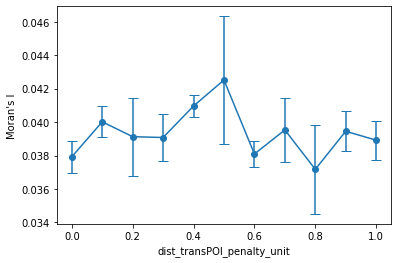

In [35]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_moran_list_grid = np.array([avg_moran_max_2,
                                avg_moran_max_3,
                                avg_moran_max_4,
                                avg_moran_max_5,
                                avg_moran_max_6,
                                avg_moran_max_7,
                                avg_moran_max_8,
                                avg_moran_max_9,
                                avg_moran_max_10,
                                avg_moran_max_11,
                                avg_moran_max_12])
max_moran_mean_grid = np.mean(max_moran_list_grid, axis=1)
max_moran_std_grid = np.std(max_moran_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_moran_mean_grid, yerr=max_moran_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Moran's I")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [36]:
max_moran_list_grid

array([[0.03662729, 0.03787454, 0.03772617, 0.0369309 , 0.03995744,
        0.03819781, 0.03912607, 0.03831887, 0.03706082, 0.03737394],
       [0.04061837, 0.04061837, 0.04061837, 0.04061837, 0.04061837,
        0.04061837, 0.04061837, 0.03861877, 0.03861877, 0.03861877],
       [0.03597072, 0.03777501, 0.04193765, 0.04166238, 0.04263926,
        0.0366693 , 0.03632259, 0.03903585, 0.03873235, 0.0405228 ],
       [0.03951931, 0.04003197, 0.04055814, 0.03920149, 0.03820985,
        0.03931501, 0.03803882, 0.04154014, 0.03651324, 0.03784383],
       [0.03897047, 0.0409525 , 0.0409525 , 0.0412534 , 0.0412534 ,
        0.0412534 , 0.0412534 , 0.0412534 , 0.0412534 , 0.0412534 ],
       [0.03886479, 0.0419368 , 0.03681146, 0.04434591, 0.04316209,
        0.03873649, 0.05104492, 0.04539764, 0.04238595, 0.04251052],
       [0.03720952, 0.03818398, 0.03716621, 0.03897871, 0.03784233,
        0.03781824, 0.03829982, 0.03947516, 0.03701417, 0.03891716],
       [0.04024845, 0.04253978, 0.0385999

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


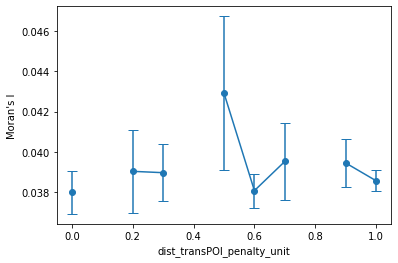

In [37]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_moran_list_grid = [np.array(avg_moran_max_2)[sel_index_2],
                        np.array(avg_moran_max_3)[sel_index_3],
                        np.array(avg_moran_max_4)[sel_index_4],
                        np.array(avg_moran_max_5)[sel_index_5],
                        np.array(avg_moran_max_6)[sel_index_6],
                        np.array(avg_moran_max_7)[sel_index_7],
                        np.array(avg_moran_max_8)[sel_index_8],
                        np.array(avg_moran_max_9)[sel_index_9],
                        np.array(avg_moran_max_10)[sel_index_10],
                        np.array(avg_moran_max_11)[sel_index_11],
                        np.array(avg_moran_max_12)[sel_index_12]]
max_moran_mean_grid = []
max_moran_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_moran_mean_grid.append(np.mean(max_moran_list_grid[ii]))
    max_moran_std_grid.append(np.std(max_moran_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_moran_mean_grid, yerr=max_moran_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Moran's I")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


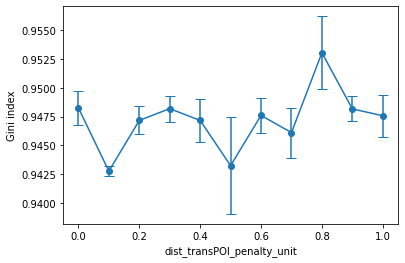

In [38]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_gini_list_grid = np.array([avg_gini_max_2,
                                avg_gini_max_3,
                                avg_gini_max_4,
                                avg_gini_max_5,
                                avg_gini_max_6,
                                avg_gini_max_7,
                                avg_gini_max_8,
                                avg_gini_max_9,
                                avg_gini_max_10,
                                avg_gini_max_11,
                                avg_gini_max_12])
max_gini_mean_grid = np.mean(max_gini_list_grid, axis=1)
max_gini_std_grid = np.std(max_gini_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_gini_mean_grid, yerr=max_gini_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Gini index")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [39]:
max_gini_list_grid

array([[0.94848681, 0.94479136, 0.94808291, 0.94998033, 0.94736647,
        0.94942154, 0.94902797, 0.94998234, 0.94843647, 0.94704281],
       [0.94303445, 0.94303445, 0.94303445, 0.94303445, 0.94303445,
        0.94303445, 0.94303445, 0.94212578, 0.94212578, 0.94212578],
       [0.94735876, 0.94725298, 0.9469361 , 0.94744421, 0.94674335,
        0.94742874, 0.94394683, 0.94822361, 0.94885508, 0.94753802],
       [0.94907318, 0.94603051, 0.94711307, 0.94775474, 0.94834847,
        0.9473207 , 0.94970127, 0.94931867, 0.94936428, 0.94793236],
       [0.94493855, 0.9440081 , 0.9440081 , 0.94838996, 0.94838996,
        0.94838996, 0.94838996, 0.94838996, 0.94838996, 0.94838996],
       [0.94660857, 0.94968562, 0.94170368, 0.93991354, 0.9402893 ,
        0.9463706 , 0.93747271, 0.93719312, 0.94667112, 0.9465065 ],
       [0.94702584, 0.9436592 , 0.94846467, 0.94836516, 0.94756306,
        0.94806012, 0.94968811, 0.94694042, 0.94771319, 0.94860075],
       [0.94509147, 0.94929565, 0.9485572

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


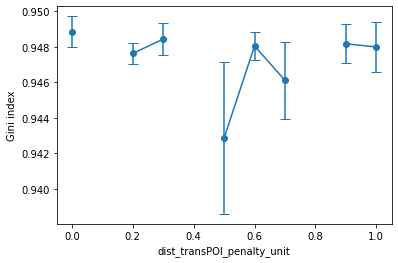

In [40]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_gini_list_grid = [np.array(avg_gini_max_2)[sel_index_2],
                        np.array(avg_gini_max_3)[sel_index_3],
                        np.array(avg_gini_max_4)[sel_index_4],
                        np.array(avg_gini_max_5)[sel_index_5],
                        np.array(avg_gini_max_6)[sel_index_6],
                        np.array(avg_gini_max_7)[sel_index_7],
                        np.array(avg_gini_max_8)[sel_index_8],
                        np.array(avg_gini_max_9)[sel_index_9],
                        np.array(avg_gini_max_10)[sel_index_10],
                        np.array(avg_gini_max_11)[sel_index_11],
                        np.array(avg_gini_max_12)[sel_index_12]]
max_gini_mean_grid = []
max_gini_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_gini_mean_grid.append(np.mean(max_gini_list_grid[ii]))
    max_gini_std_grid.append(np.std(max_gini_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_gini_mean_grid, yerr=max_gini_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Gini index")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


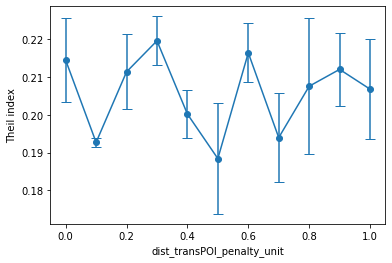

In [41]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_theil_list_grid = np.array([avg_theil_max_2,
                                avg_theil_max_3,
                                avg_theil_max_4,
                                avg_theil_max_5,
                                avg_theil_max_6,
                                avg_theil_max_7,
                                avg_theil_max_8,
                                avg_theil_max_9,
                                avg_theil_max_10,
                                avg_theil_max_11,
                                avg_theil_max_12])
max_theil_mean_grid = np.mean(max_theil_list_grid, axis=1)
max_theil_std_grid = np.std(max_theil_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_theil_mean_grid, yerr=max_theil_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Theil index")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [42]:
max_theil_list_grid

array([[0.20987804, 0.18528683, 0.21204798, 0.21637606, 0.22119235,
        0.21759599, 0.22391429, 0.21064635, 0.22496301, 0.22245063],
       [0.19347005, 0.19347005, 0.19347005, 0.19347005, 0.19347005,
        0.19347005, 0.19347005, 0.19093516, 0.19093516, 0.19093516],
       [0.2237939 , 0.22671758, 0.20414182, 0.20200089, 0.20473314,
        0.21159156, 0.20345199, 0.21250734, 0.22523499, 0.19928158],
       [0.22592601, 0.21127415, 0.2104253 , 0.21624621, 0.21394228,
        0.22211652, 0.22272133, 0.21797288, 0.23189804, 0.22299237],
       [0.18850611, 0.19149512, 0.19149512, 0.2043403 , 0.2043403 ,
        0.2043403 , 0.2043403 , 0.2043403 , 0.2043403 , 0.2043403 ],
       [0.18772624, 0.20298813, 0.19081925, 0.17256626, 0.1989504 ,
        0.20665251, 0.18087385, 0.15519379, 0.19572378, 0.19267088],
       [0.21169267, 0.20969097, 0.22396046, 0.2106731 , 0.20774823,
        0.20820844, 0.22797051, 0.22078156, 0.21428408, 0.22870077],
       [0.17436149, 0.19200895, 0.1741347

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


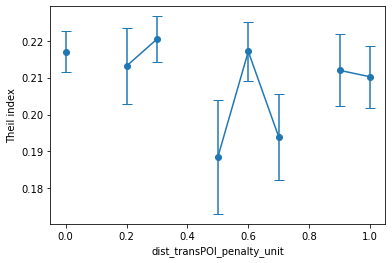

In [43]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_theil_list_grid = [np.array(avg_theil_max_2)[sel_index_2],
                        np.array(avg_theil_max_3)[sel_index_3],
                        np.array(avg_theil_max_4)[sel_index_4],
                        np.array(avg_theil_max_5)[sel_index_5],
                        np.array(avg_theil_max_6)[sel_index_6],
                        np.array(avg_theil_max_7)[sel_index_7],
                        np.array(avg_theil_max_8)[sel_index_8],
                        np.array(avg_theil_max_9)[sel_index_9],
                        np.array(avg_theil_max_10)[sel_index_10],
                        np.array(avg_theil_max_11)[sel_index_11],
                        np.array(avg_theil_max_12)[sel_index_12]]
max_theil_mean_grid = []
max_theil_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_theil_mean_grid.append(np.mean(max_theil_list_grid[ii]))
    max_theil_std_grid.append(np.std(max_theil_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_theil_mean_grid, yerr=max_theil_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Theil index")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:47
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:47


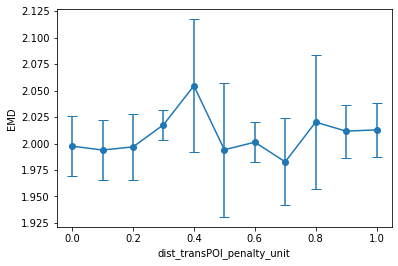

In [44]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_EMD_list_grid = np.array([avg_EMD_max_2,
                                avg_EMD_max_3,
                                avg_EMD_max_4,
                                avg_EMD_max_5,
                                avg_EMD_max_6,
                                avg_EMD_max_7,
                                avg_EMD_max_8,
                                avg_EMD_max_9,
                                avg_EMD_max_10,
                                avg_EMD_max_11,
                                avg_EMD_max_12])
max_EMD_mean_grid = np.mean(max_EMD_list_grid, axis=1)
max_EMD_std_grid = np.std(max_EMD_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_EMD_mean_grid, yerr=max_EMD_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("EMD")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [45]:
max_EMD_list_grid

array([[1.98751409, 1.93524014, 1.98096289, 2.02664629, 2.01590594,
        2.01602415, 2.0212867 , 2.02413609, 2.00198094, 1.96545213],
       [2.01213854, 2.01213854, 2.01213854, 2.01213854, 2.01213854,
        2.01213854, 2.01213854, 1.95114537, 1.95114537, 1.95114537],
       [1.95401444, 2.00393828, 2.02928016, 2.0253028 , 2.03597788,
        1.96330615, 1.94164701, 2.00229595, 2.01291899, 1.99945697],
       [2.00738265, 2.01704693, 2.02144671, 2.01130952, 2.00701761,
        2.02000199, 2.02081866, 2.05633908, 2.00190091, 2.01339387],
       [1.97169602, 1.95266581, 1.95266581, 2.09540208, 2.09540208,
        2.09540208, 2.09540208, 2.09540208, 2.09540208, 2.09540208],
       [1.97334687, 2.10447572, 1.90436439, 1.94000858, 1.94839347,
        1.97758638, 2.01548982, 1.94085455, 2.0645561 , 2.07189406],
       [1.97249551, 1.97226632, 2.02243138, 2.0104226 , 1.99129507,
        1.99213981, 2.03247326, 2.00411362, 1.99749327, 2.01728747],
       [1.95253998, 2.07221224, 1.9407384

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


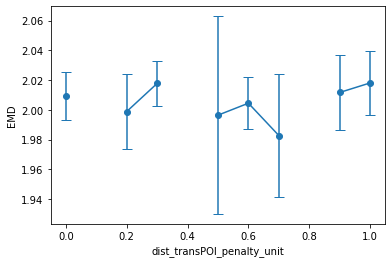

In [46]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_EMD_list_grid = [np.array(avg_EMD_max_2)[sel_index_2],
                        np.array(avg_EMD_max_3)[sel_index_3],
                        np.array(avg_EMD_max_4)[sel_index_4],
                        np.array(avg_EMD_max_5)[sel_index_5],
                        np.array(avg_EMD_max_6)[sel_index_6],
                        np.array(avg_EMD_max_7)[sel_index_7],
                        np.array(avg_EMD_max_8)[sel_index_8],
                        np.array(avg_EMD_max_9)[sel_index_9],
                        np.array(avg_EMD_max_10)[sel_index_10],
                        np.array(avg_EMD_max_11)[sel_index_11],
                        np.array(avg_EMD_max_12)[sel_index_12]]
max_EMD_mean_grid = []
max_EMD_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_EMD_mean_grid.append(np.mean(max_EMD_list_grid[ii]))
    max_EMD_std_grid.append(np.std(max_EMD_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_EMD_mean_grid, yerr=max_EMD_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("EMD")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


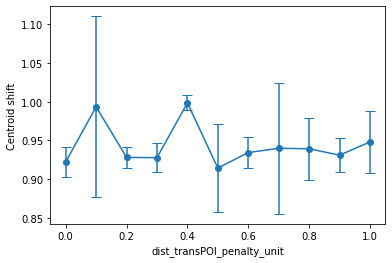

In [47]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_centroid_list_grid = np.array([avg_centroid_max_2,
                                avg_centroid_max_3,
                                avg_centroid_max_4,
                                avg_centroid_max_5,
                                avg_centroid_max_6,
                                avg_centroid_max_7,
                                avg_centroid_max_8,
                                avg_centroid_max_9,
                                avg_centroid_max_10,
                                avg_centroid_max_11,
                                avg_centroid_max_12])
max_centroid_mean_grid = np.mean(max_centroid_list_grid, axis=1)
max_centroid_std_grid = np.std(max_centroid_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_centroid_mean_grid, yerr=max_centroid_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Centroid shift")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [48]:
max_centroid_list_grid

array([[0.93048523, 0.8753432 , 0.93349994, 0.93570934, 0.92411396,
        0.91237829, 0.90582656, 0.91700952, 0.94767386, 0.94001667],
       [1.07016289, 1.07016289, 1.07016289, 1.07016289, 1.07016289,
        1.07016289, 1.07016289, 0.81508793, 0.81508793, 0.81508793],
       [0.94176718, 0.92671779, 0.92369731, 0.92527224, 0.92649244,
        0.95709579, 0.92939191, 0.93563285, 0.90933536, 0.90593687],
       [0.90969504, 0.96401028, 0.92975296, 0.9194731 , 0.94570642,
        0.9229644 , 0.93535227, 0.91396866, 0.89583403, 0.94110765],
       [0.97053397, 1.00549766, 1.00549766, 1.00072092, 1.00072092,
        1.00072092, 1.00072092, 1.00072092, 1.00072092, 1.00072092],
       [0.9725678 , 0.95193856, 0.86962595, 0.84640009, 0.90629522,
        0.90315879, 1.03027481, 0.89108819, 0.83721304, 0.93467102],
       [0.95821804, 0.94855249, 0.93669048, 0.939921  , 0.96716796,
        0.92904486, 0.91925393, 0.89787566, 0.93065617, 0.91664374],
       [0.95949126, 0.95406065, 0.8595368

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


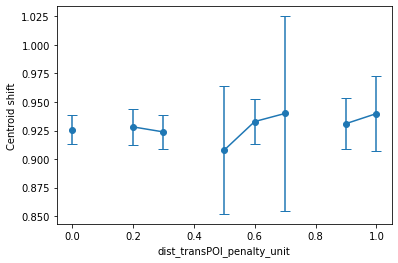

In [49]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_centroid_list_grid = [np.array(avg_centroid_max_2)[sel_index_2],
                        np.array(avg_centroid_max_3)[sel_index_3],
                        np.array(avg_centroid_max_4)[sel_index_4],
                        np.array(avg_centroid_max_5)[sel_index_5],
                        np.array(avg_centroid_max_6)[sel_index_6],
                        np.array(avg_centroid_max_7)[sel_index_7],
                        np.array(avg_centroid_max_8)[sel_index_8],
                        np.array(avg_centroid_max_9)[sel_index_9],
                        np.array(avg_centroid_max_10)[sel_index_10],
                        np.array(avg_centroid_max_11)[sel_index_11],
                        np.array(avg_centroid_max_12)[sel_index_12]]
max_centroid_mean_grid = []
max_centroid_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_centroid_mean_grid.append(np.mean(max_centroid_list_grid[ii]))
    max_centroid_std_grid.append(np.std(max_centroid_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_centroid_mean_grid, yerr=max_centroid_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Centroid shift")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


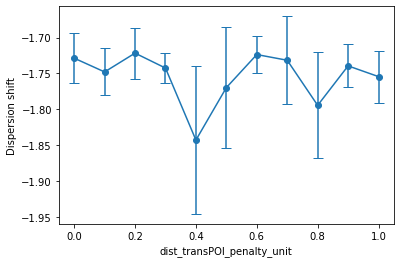

In [50]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_dispersion_list_grid = np.array([avg_dispersion_max_2,
                                avg_dispersion_max_3,
                                avg_dispersion_max_4,
                                avg_dispersion_max_5,
                                avg_dispersion_max_6,
                                avg_dispersion_max_7,
                                avg_dispersion_max_8,
                                avg_dispersion_max_9,
                                avg_dispersion_max_10,
                                avg_dispersion_max_11,
                                avg_dispersion_max_12])
max_dispersion_mean_grid = np.mean(max_dispersion_list_grid, axis=1)
max_dispersion_std_grid = np.std(max_dispersion_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_dispersion_mean_grid, yerr=max_dispersion_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Dispersion shift")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [51]:
max_dispersion_list_grid

array([[-1.72216354, -1.64920733, -1.70733752, -1.77644318, -1.74492456,
        -1.75698769, -1.74869476, -1.75678858, -1.72108892, -1.70249333],
       [-1.76926438, -1.76926438, -1.76926438, -1.76926438, -1.76926438,
        -1.76926438, -1.76926438, -1.69780608, -1.69780608, -1.69780608],
       [-1.66428347, -1.72372744, -1.76534918, -1.75629833, -1.76290928,
        -1.6704632 , -1.68160928, -1.72620676, -1.72705582, -1.73783801],
       [-1.71184576, -1.75907946, -1.75466785, -1.73810281, -1.73075661,
        -1.74545078, -1.74252159, -1.78667785, -1.71354188, -1.74150951],
       [-1.70549762, -1.67582474, -1.67582474, -1.91027013, -1.91027013,
        -1.91027013, -1.91027013, -1.91027013, -1.91027013, -1.91027013],
       [-1.67887836, -1.92617596, -1.66768427, -1.71765851, -1.72348127,
        -1.72402889, -1.78224615, -1.74046667, -1.89625622, -1.84020135],
       [-1.69384554, -1.68164606, -1.76679823, -1.73705189, -1.71238744,
        -1.71460871, -1.75850317, -1.7291468 

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


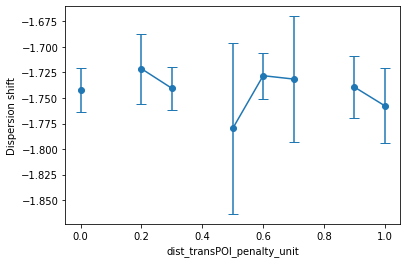

In [52]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_dispersion_list_grid = [np.array(avg_dispersion_max_2)[sel_index_2],
                        np.array(avg_dispersion_max_3)[sel_index_3],
                        np.array(avg_dispersion_max_4)[sel_index_4],
                        np.array(avg_dispersion_max_5)[sel_index_5],
                        np.array(avg_dispersion_max_6)[sel_index_6],
                        np.array(avg_dispersion_max_7)[sel_index_7],
                        np.array(avg_dispersion_max_8)[sel_index_8],
                        np.array(avg_dispersion_max_9)[sel_index_9],
                        np.array(avg_dispersion_max_10)[sel_index_10],
                        np.array(avg_dispersion_max_11)[sel_index_11],
                        np.array(avg_dispersion_max_12)[sel_index_12]]
max_dispersion_mean_grid = []
max_dispersion_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_dispersion_mean_grid.append(np.mean(max_dispersion_list_grid[ii]))
    max_dispersion_std_grid.append(np.std(max_dispersion_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_dispersion_mean_grid, yerr=max_dispersion_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Dispersion shift")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


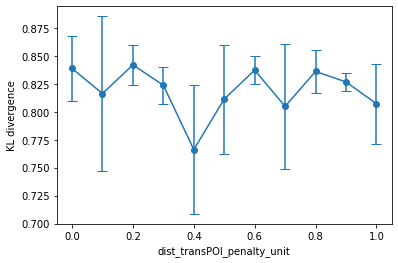

In [53]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_kl_list_grid = np.array([avg_kl_max_2,
                                avg_kl_max_3,
                                avg_kl_max_4,
                                avg_kl_max_5,
                                avg_kl_max_6,
                                avg_kl_max_7,
                                avg_kl_max_8,
                                avg_kl_max_9,
                                avg_kl_max_10,
                                avg_kl_max_11,
                                avg_kl_max_12])
max_kl_mean_grid = np.mean(max_kl_list_grid, axis=1)
max_kl_std_grid = np.std(max_kl_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_kl_mean_grid, yerr=max_kl_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("KL divergence")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [54]:
max_kl_list_grid

array([[0.85353463, 0.90131431, 0.85023566, 0.84828408, 0.83174694,
        0.83990849, 0.82214841, 0.81617478, 0.84536486, 0.78024579],
       [0.77119695, 0.77119695, 0.77119695, 0.77119695, 0.77119695,
        0.77119695, 0.77119695, 0.92205311, 0.92205311, 0.92205311],
       [0.84256005, 0.84793652, 0.82301683, 0.80911068, 0.84511398,
        0.86148514, 0.83911243, 0.84007544, 0.83630655, 0.87647393],
       [0.82385803, 0.80754082, 0.81982887, 0.81176229, 0.83230393,
        0.80759289, 0.83455054, 0.80106897, 0.84889977, 0.85156278],
       [0.82779032, 0.86580447, 0.86580447, 0.72905486, 0.72905486,
        0.72905486, 0.72905486, 0.72905486, 0.72905486, 0.72905486],
       [0.87125592, 0.70872092, 0.84084704, 0.8165734 , 0.87339343,
        0.8088688 , 0.76280567, 0.8418955 , 0.77186446, 0.81859215],
       [0.85044739, 0.85565795, 0.83352248, 0.81983087, 0.83244453,
        0.82340383, 0.83574691, 0.83622444, 0.85717816, 0.82944596],
       [0.85832462, 0.78118658, 0.8059411

End: 2025-07-13 03:42:48
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-13 03:42:48


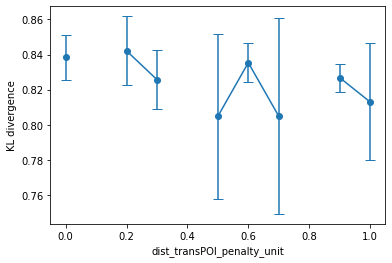

In [55]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_kl_list_grid = [np.array(avg_kl_max_2)[sel_index_2],
                        np.array(avg_kl_max_3)[sel_index_3],
                        np.array(avg_kl_max_4)[sel_index_4],
                        np.array(avg_kl_max_5)[sel_index_5],
                        np.array(avg_kl_max_6)[sel_index_6],
                        np.array(avg_kl_max_7)[sel_index_7],
                        np.array(avg_kl_max_8)[sel_index_8],
                        np.array(avg_kl_max_9)[sel_index_9],
                        np.array(avg_kl_max_10)[sel_index_10],
                        np.array(avg_kl_max_11)[sel_index_11],
                        np.array(avg_kl_max_12)[sel_index_12]]
max_kl_mean_grid = []
max_kl_std_grid = []
for ii in range(len(dist_transPOI_penalty_unit_list)):
    max_kl_mean_grid.append(np.mean(max_kl_list_grid[ii]))
    max_kl_std_grid.append(np.std(max_kl_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(dist_transPOI_penalty_unit_list, max_kl_mean_grid, yerr=max_kl_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("KL divergence")
plt.xlabel("dist_transPOI_penalty_unit")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))